2. PHẦN MÔ HÌNH TRỘN GAUSSIAN (GAUSSIAN MIXTURE
MODEL)

In [59]:
import numpy as np
from numpy import random
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal

class GMM():
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
        '''
        Define a model with known number of clusters and dimensions.
        input:
            - k: Number of Gaussian clusters
            - dim: Dimension
            - init_mu: initial value of mean of clusters (k, dim)
                       (default) random from uniform[-10, 10]
            - init_sigma: initial value of covariance matrix of clusters (k, dim, dim)
                          (default) Identity matrix for each cluster
            - init_pi: initial value of cluster weights (k,)
                       (default) equal value to all cluster i.e. 1/k
            - colors: Color valu for plotting each cluster (k, 3)
                      (default) random from uniform[0, 1]
        '''
        self.k = k
        self.dim = dim
        if(init_mu is None):
            init_mu = random.rand(k, dim)*20 - 10
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        if(init_pi is None):
            init_pi = np.ones(self.k)/self.k
        self.pi = init_pi
        if(colors is None):
            colors = random.rand(k, 3)
            for i in range(k):
                colors[i, 2] = i/k
        self.colors = colors

    def init_em(self, X):
        '''
        Initialization for EM algorithm.
        input:
            - X: data (batch_size, dim)
        '''
        self.data = X
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))

    def e_step(self):
        '''
        E-step of EM algorithm.
        '''
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
        self.z /= self.z.sum(axis=1, keepdims=True)

    def m_step(self):
        '''
        M-step of EM algorithm.
        '''
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.num_points
        self.mu = np.matmul(self.z.T, self.data)
        self.mu /= sum_z[:, None]
        for i in range(self.k):
            j = np.expand_dims(self.data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]

    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(d, mean=self.mu[i], cov=self.sigma[i])
            ll.append(np.log(tot))
        return np.sum(ll)

    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

    def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=self.colors[i], **kwargs)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


In [15]:
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random mixture of Gaussians in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    mean = random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = random.rand(dim, dim+10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    if(dim == 2):
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True)
    return x


In [16]:
def plot(title):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved.
    '''
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(X[:, 0], X[:, 1], s=3, alpha=0.4)
    ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], c=gmm.colors)
    gmm.draw(ax, lw=3)
    ax.set_xlim((-22, 22))
    ax.set_ylim((-22, 22))

    plt.title(title)
    plt.savefig(title.replace(':', '_'))
    plt.show()
    plt.clf()

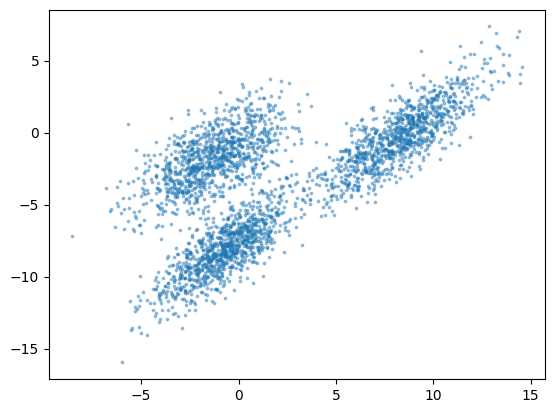

In [17]:
# Generate random 2D data with 3 clusters
X = gen_data(k=3, dim=2, points_per_cluster=1000)

In [18]:
# Create a Gaussian Mixture Model
gmm = GMM(3, 2)

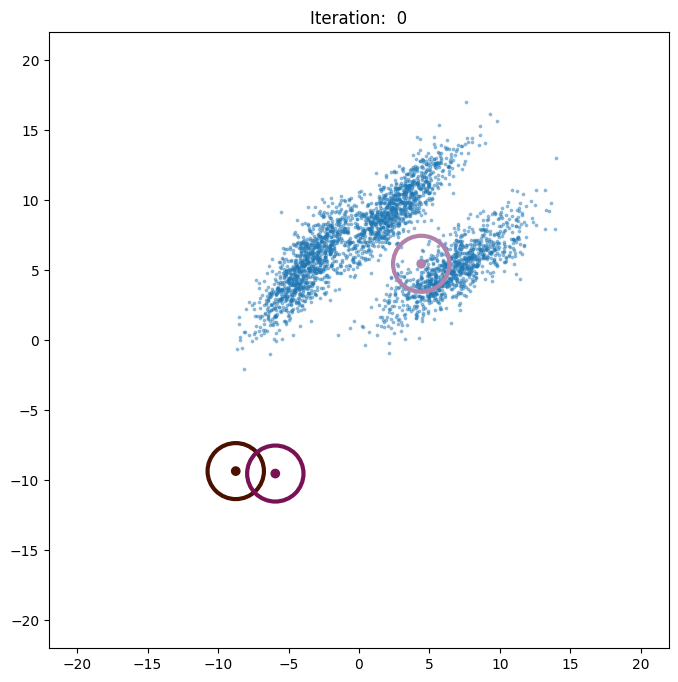

Iteration: 1, log-likelihood: -16238.8375


<Figure size 640x480 with 0 Axes>

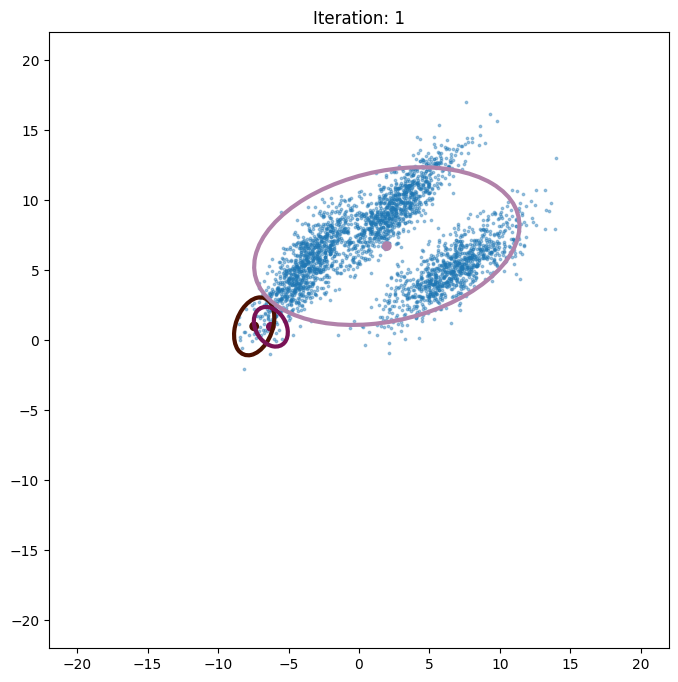

Iteration: 2, log-likelihood: -16215.9589


<Figure size 640x480 with 0 Axes>

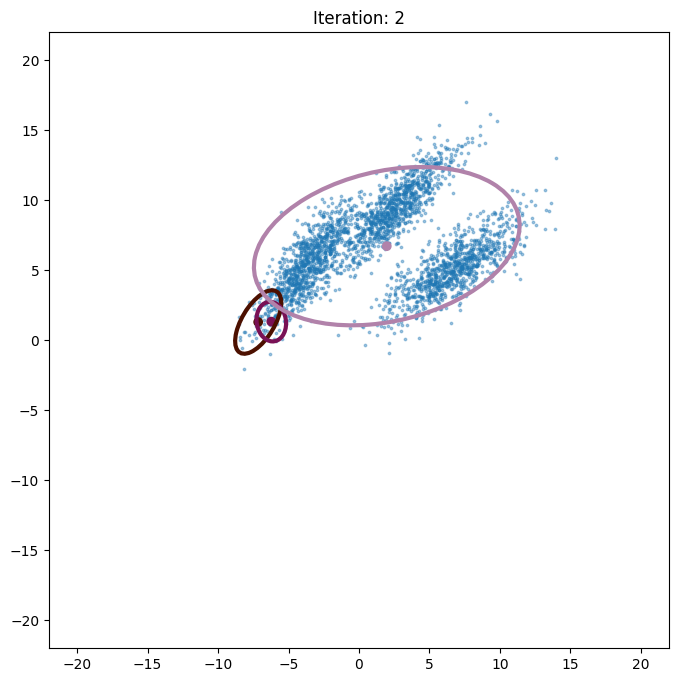

Iteration: 3, log-likelihood: -16187.0976


<Figure size 640x480 with 0 Axes>

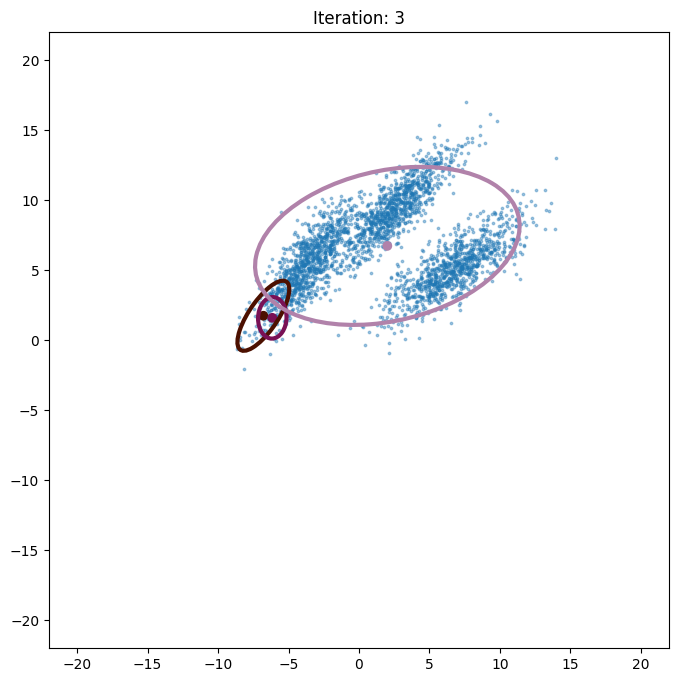

Iteration: 4, log-likelihood: -16139.6759


<Figure size 640x480 with 0 Axes>

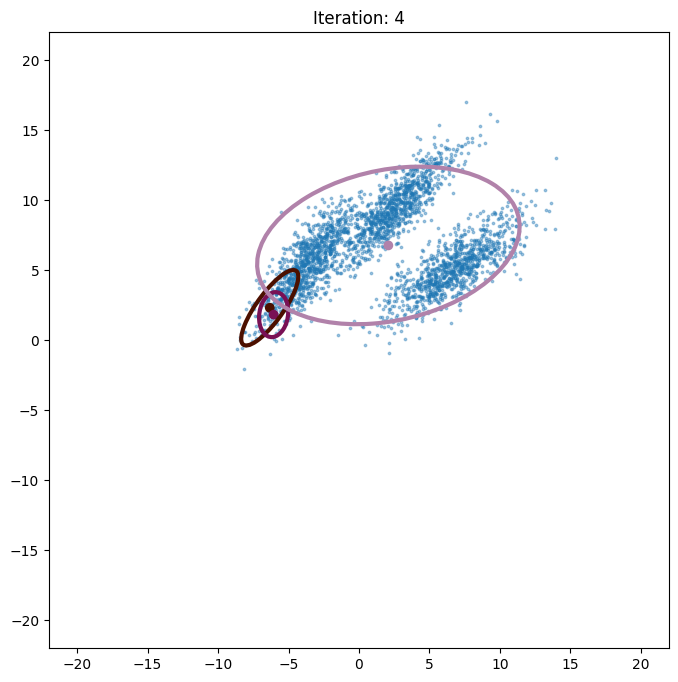

Iteration: 5, log-likelihood: -16062.0786


<Figure size 640x480 with 0 Axes>

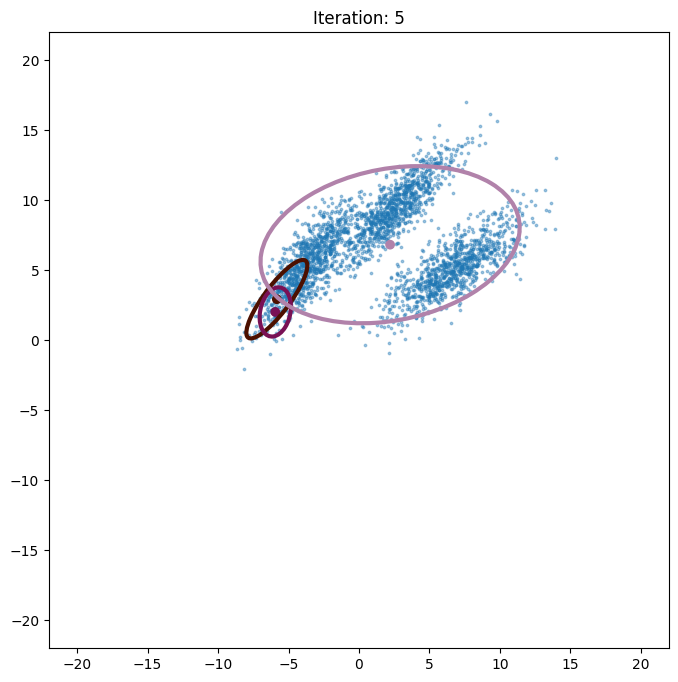

Iteration: 6, log-likelihood: -15954.9689


<Figure size 640x480 with 0 Axes>

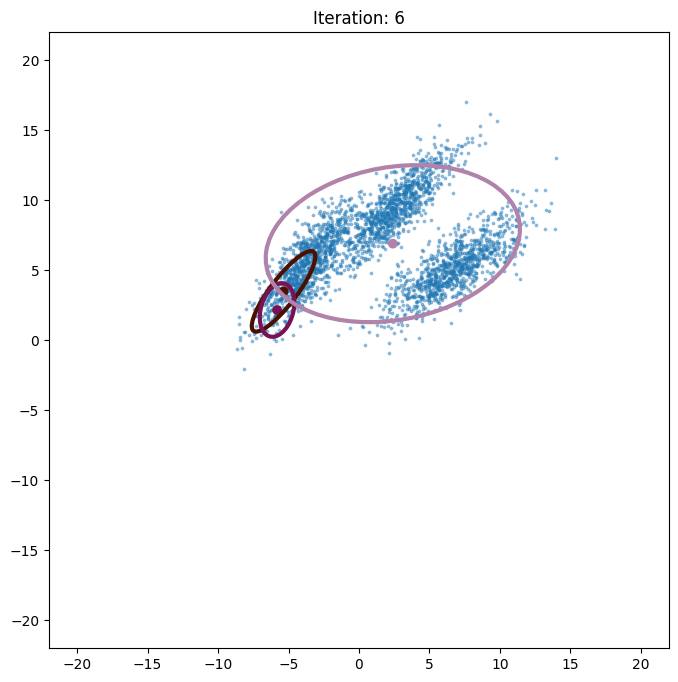

Iteration: 7, log-likelihood: -15838.7703


<Figure size 640x480 with 0 Axes>

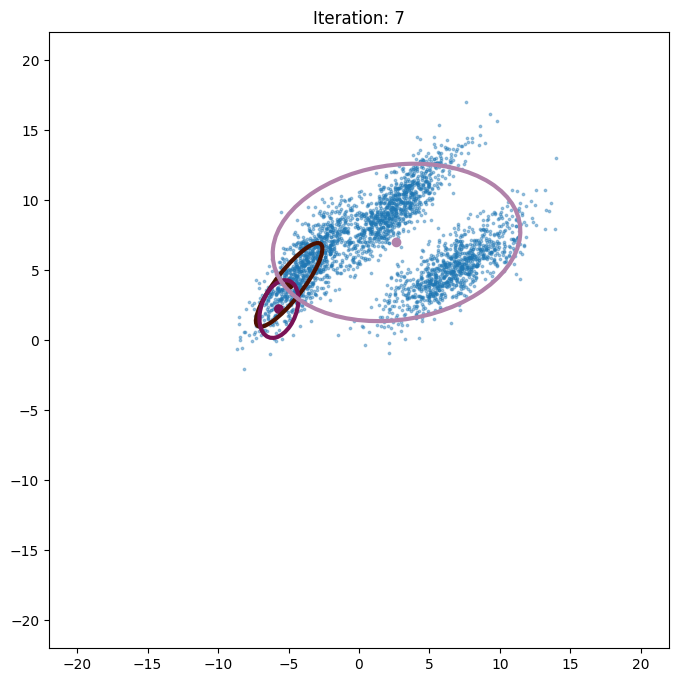

Iteration: 8, log-likelihood: -15730.9969


<Figure size 640x480 with 0 Axes>

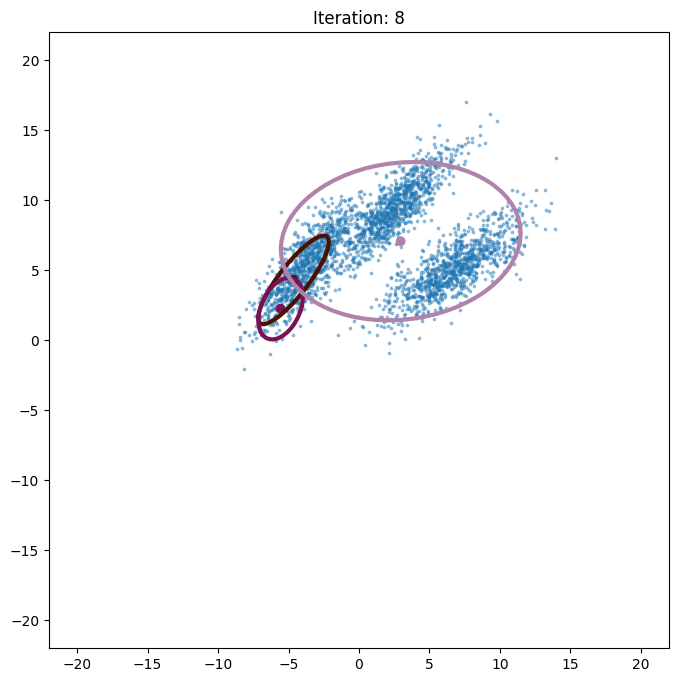

Iteration: 9, log-likelihood: -15637.6711


<Figure size 640x480 with 0 Axes>

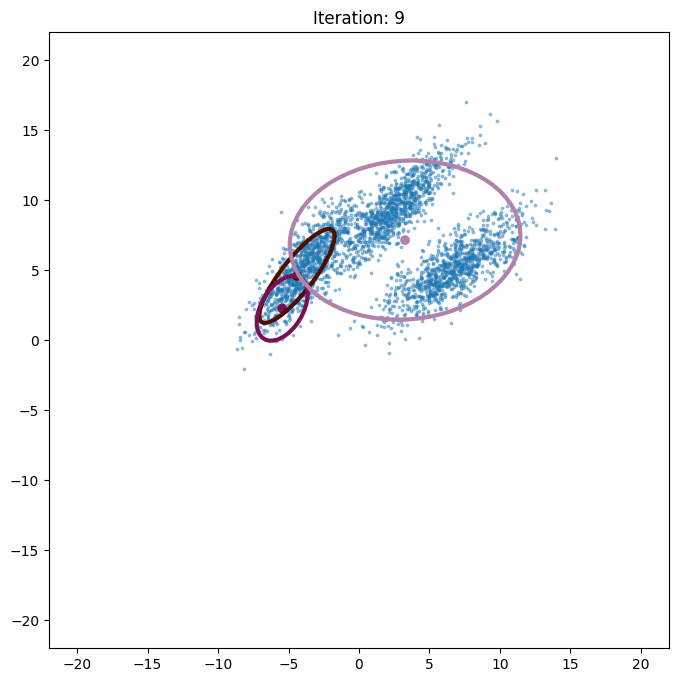

Iteration: 10, log-likelihood: -15562.8919


<Figure size 640x480 with 0 Axes>

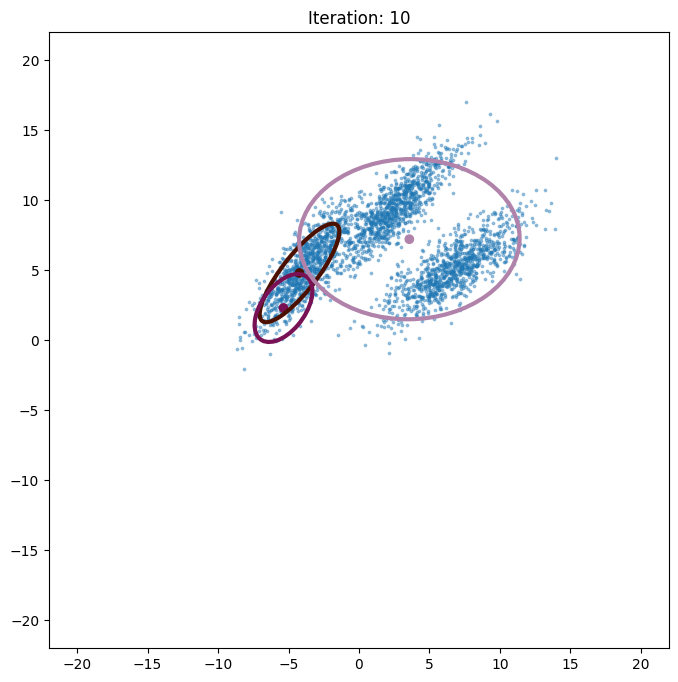

Iteration: 11, log-likelihood: -15508.5043


<Figure size 640x480 with 0 Axes>

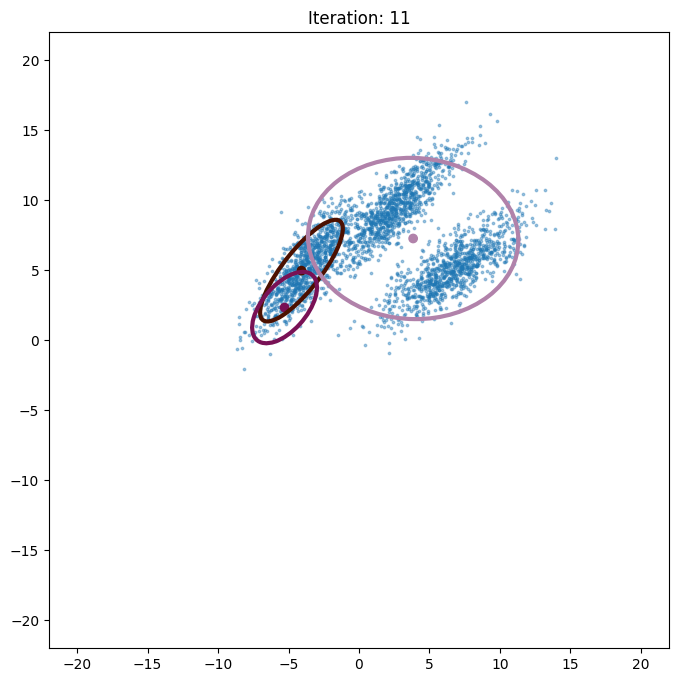

Iteration: 12, log-likelihood: -15472.6838


<Figure size 640x480 with 0 Axes>

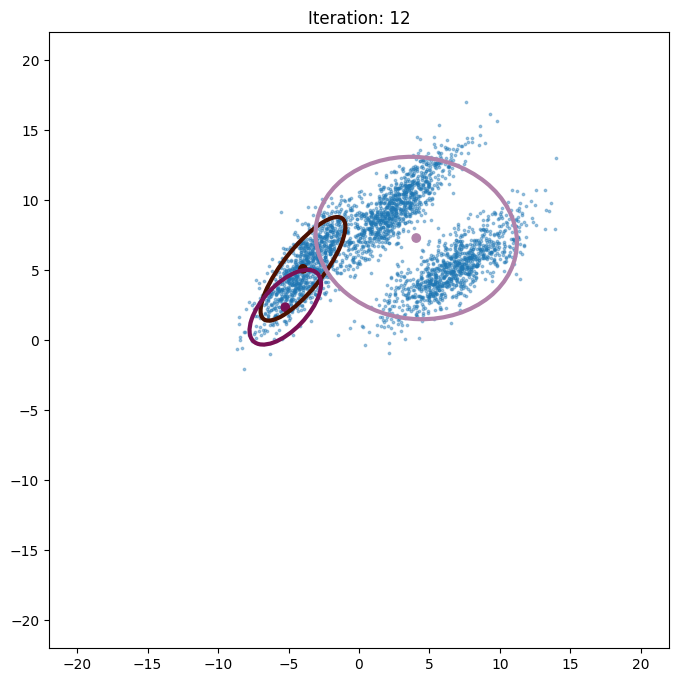

Iteration: 13, log-likelihood: -15451.6041


<Figure size 640x480 with 0 Axes>

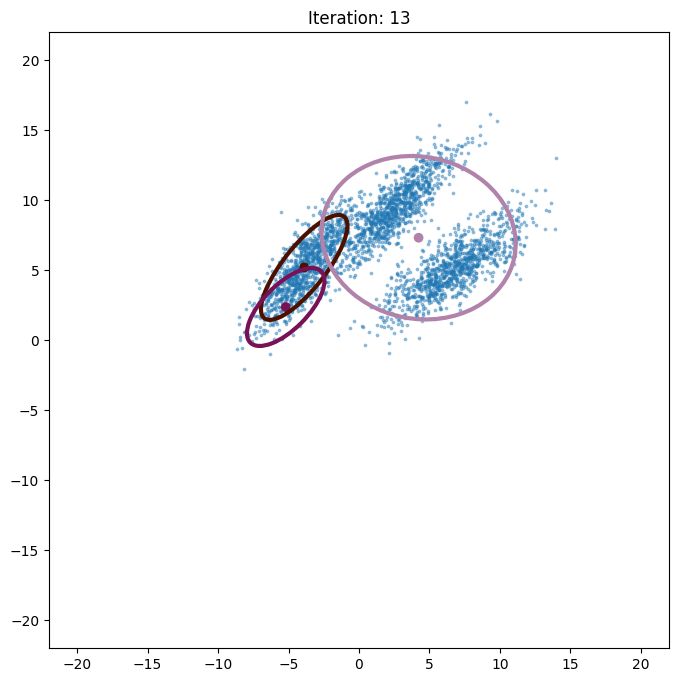

Iteration: 14, log-likelihood: -15440.3207


<Figure size 640x480 with 0 Axes>

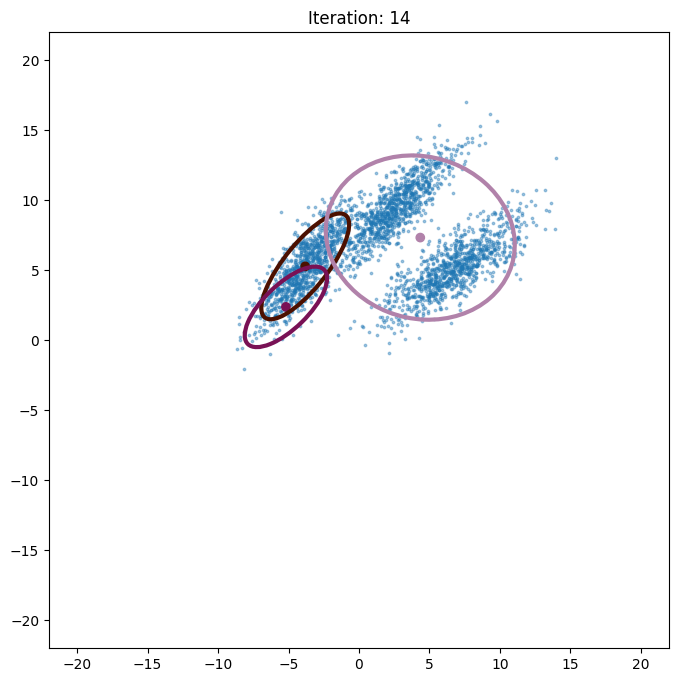

Iteration: 15, log-likelihood: -15434.5064


<Figure size 640x480 with 0 Axes>

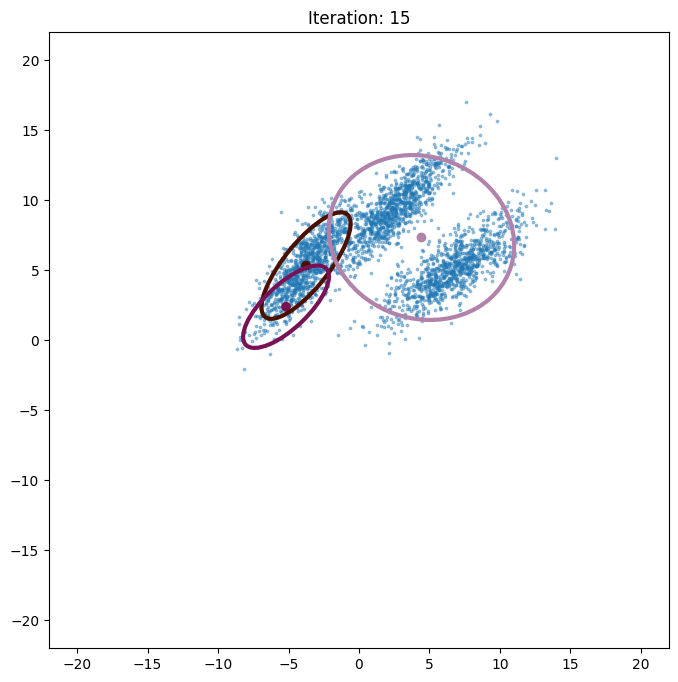

Iteration: 16, log-likelihood: -15431.4450


<Figure size 640x480 with 0 Axes>

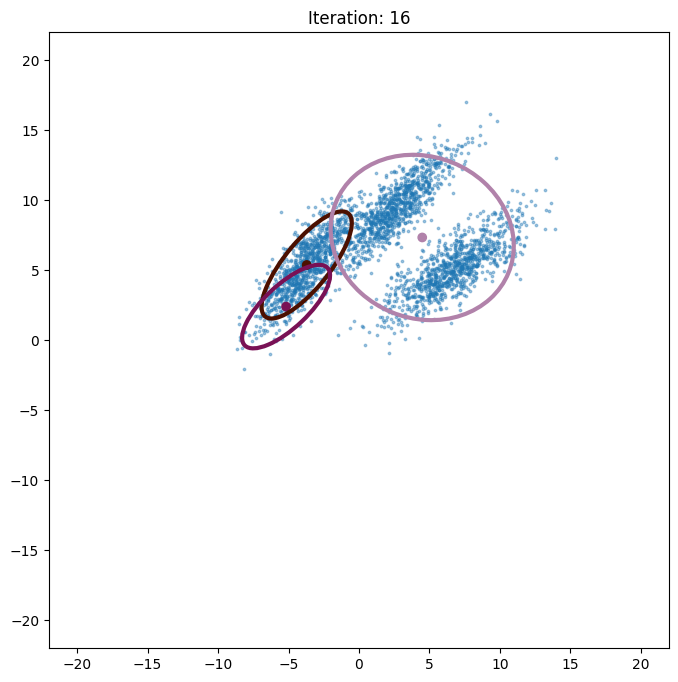

Iteration: 17, log-likelihood: -15429.7261


<Figure size 640x480 with 0 Axes>

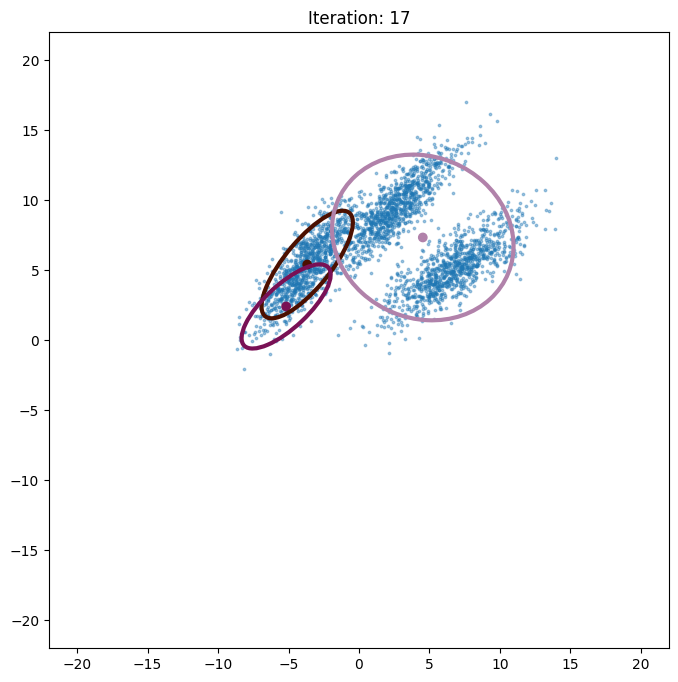

Iteration: 18, log-likelihood: -15428.6754


<Figure size 640x480 with 0 Axes>

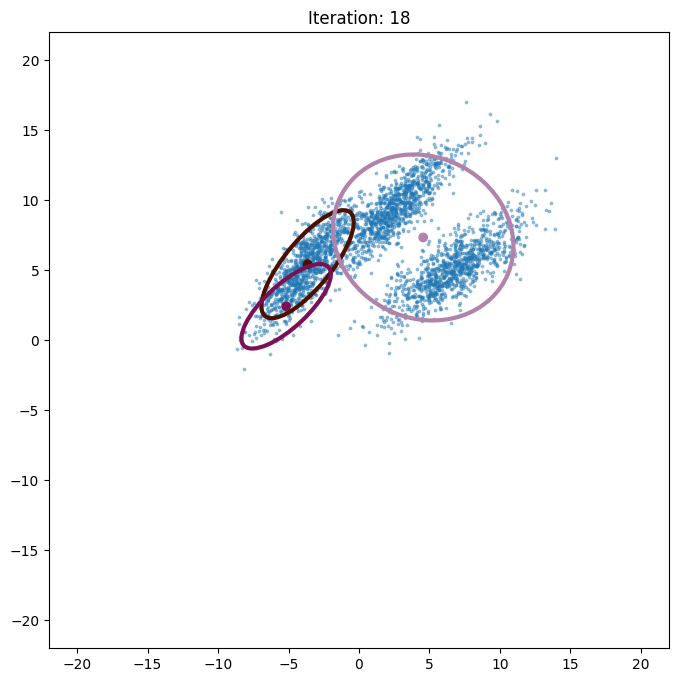

Iteration: 19, log-likelihood: -15427.9736


<Figure size 640x480 with 0 Axes>

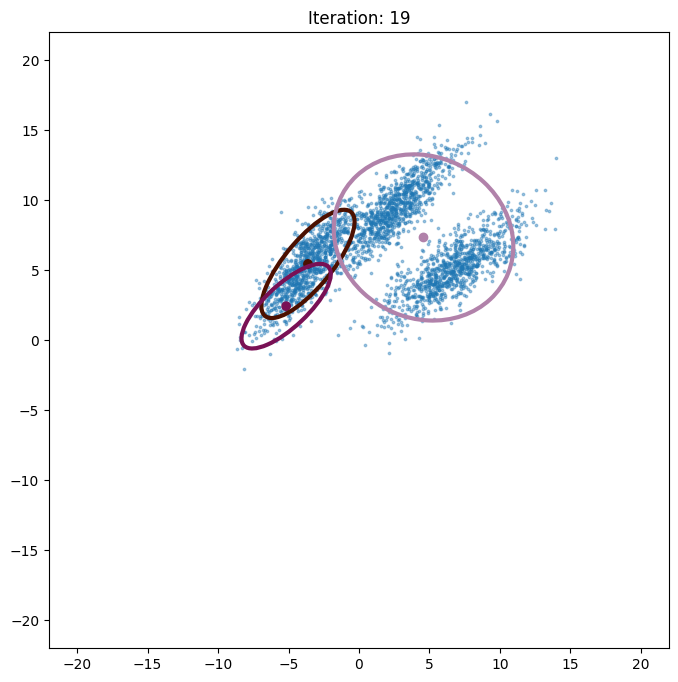

Iteration: 20, log-likelihood: -15427.4644


<Figure size 640x480 with 0 Axes>

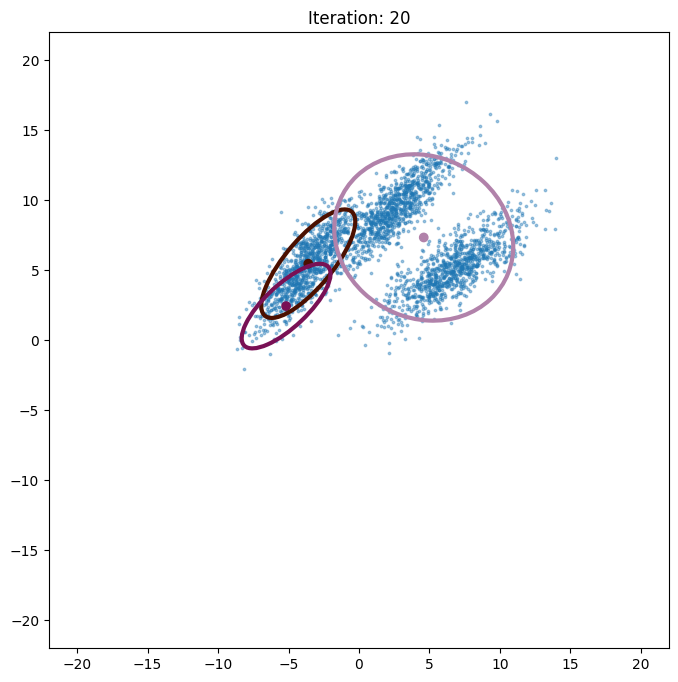

<Figure size 640x480 with 0 Axes>

In [7]:
# Training the GMM using EM

# Initialize EM algo with data
gmm.init_em(X)

num_iters = 20
# Saving log-likelihood
log_likelihood = [gmm.log_likelihood(X)]
# plotting
plot("Iteration:  0")
for e in range(num_iters):
    # E-step
    gmm.e_step()
    # M-step
    gmm.m_step()
    # Computing log-likelihood
    log_likelihood.append(gmm.log_likelihood(X))
    print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihood[-1]))
    # plotting
    plot(title="Iteration: " + str(e+1))

####Bài tập tự thực hành 1

In [21]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
import numpy as np

# 1. Load và tiền xử lý dữ liệu Iris
iris = load_iris()
X = iris.data  # Bỏ nhãn
y_true = iris.target  # Nhãn thật để so sánh sau

# Chuẩn hóa dữ liệu để tránh covariance kém
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Khởi tạo và huấn luyện GMM
gmm = GMM(k=3, dim=4)  # 3 cụm, dữ liệu 4 chiều
gmm.init_em(X_scaled)

# Chạy EM 20 vòng
for _ in range(20):
    try:
        gmm.e_step()
        gmm.m_step()
    except np.linalg.LinAlgError:
        # Nếu lỗi xảy ra, bỏ qua cụm đó
        print("Warning: singular covariance encountered. Skipping this iteration.")
        continue

# 3. Lấy nhãn dự đoán (cluster có xác suất cao nhất)
y_pred = np.argmax(gmm.z, axis=1)

# 4. So sánh với nhãn thật bằng Adjusted Rand Index (ARI)
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(y_true, y_pred)
print(f"Adjusted Rand Index: {ari:.4f}")


Adjusted Rand Index: 0.0169


####Bài tập tự thực hành 2

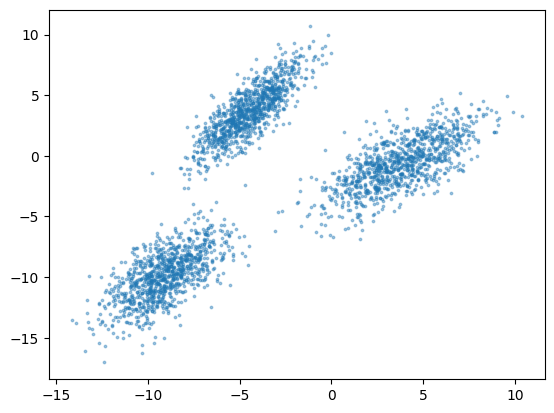

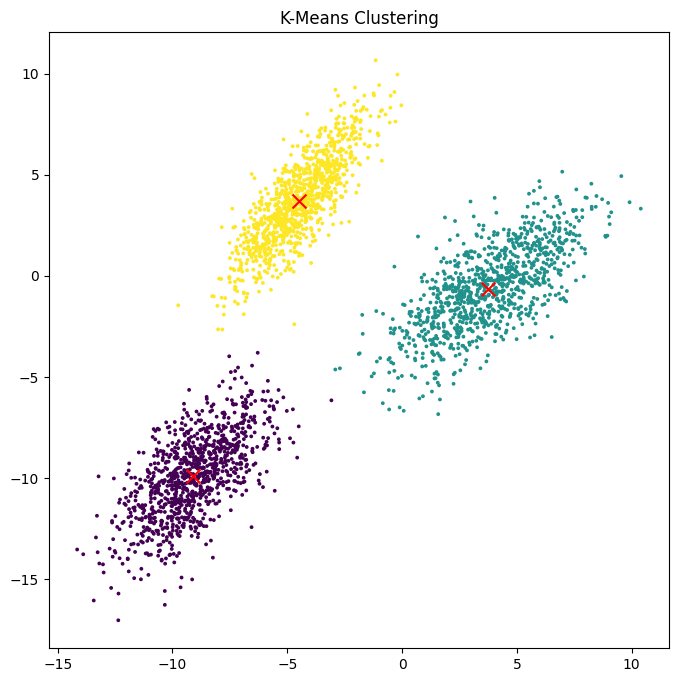

In [23]:
from sklearn.cluster import KMeans
# Sử dụng hàm gen_data đã có để tạo dữ liệu
X = gen_data(k=3, dim=2, points_per_cluster=1000)

# Áp dụng KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)
labels_kmeans = kmeans.labels_

# Vẽ phân cụm KMeans
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.scatter(X[:, 0], X[:, 1], c=labels_kmeans, s=3, cmap='viridis')
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=100, marker='x')
plt.title("K-Means Clustering")
plt.show()


##Ví dụ 2

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Ellipse
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
# Thư viện chứa model Gaussian Mixture

In [26]:
data = pd.read_csv("/content/shopping-data.csv",header=0,index_col=0)

print(data.shape)
data.head()
# Lấy ra thu nhập va điểm shopping
X = data.iloc[:, 2:4].values
# Chuẩn hoá dữ liệu
std = MinMaxScaler()
X_std = std.fit_transform(X)
print(X_std.shape)

# Khởi tạo đối tượng mô hình GaussianMixture
gm = GaussianMixture(n_components=5,
covariance_type='full',
random_state=0)

gm.fit(X_std)
print('means: \n', gm.means_)
print('covariances: \n ', gm.covariances_)

(200, 4)
(200, 2)
means: 
 [[0.33368985 0.49394756]
 [0.60502531 0.15433196]
 [0.58393969 0.82673863]
 [0.09861098 0.21597752]
 [0.0829305  0.80743088]]
covariances: 
  [[[ 0.00613567 -0.00231927]
  [-0.00231927  0.0051635 ]]

 [[ 0.01818446  0.00433814]
  [ 0.00433814  0.00873064]]

 [[ 0.01808598 -0.00031096]
  [-0.00031096  0.0091568 ]]

 [[ 0.00453005  0.00255303]
  [ 0.00255303  0.01918353]]

 [[ 0.00337483 -0.0001437 ]
  [-0.0001437   0.01026088]]]


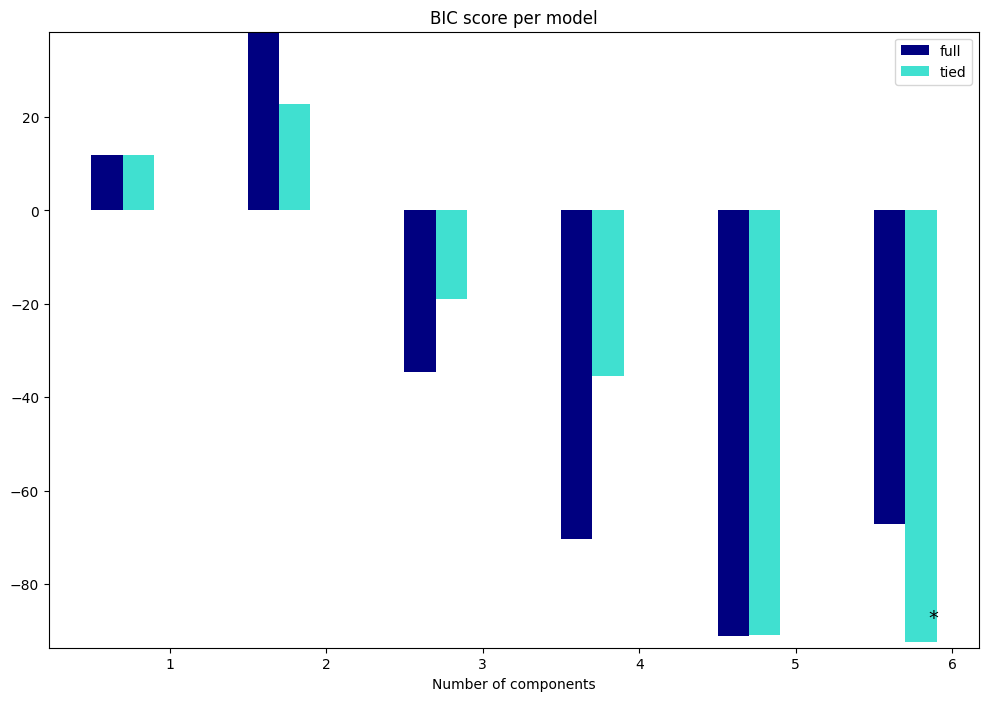

In [27]:
lowest_bic = np.inf
bic = []
n_components_range = range(1, 7)
cv_types = ['full', 'tied']

for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit Gaussian mixture theo phương pháp huấn luyện EM
        gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X_std)
        bic.append(gmm.bic(X_std))

        # Gán model có BIC score thấp nhất là model tốt nhất
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise'])
clf = best_gmm
bars = []

# Vẽ biểu đồ BIC scores
plt.figure(figsize=(12, 8))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range):(i + 1) * len(n_components_range)],
            width=.2,
            color=color
        )
    )

plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')

xpos = (
    np.mod(bic.argmin(), len(n_components_range)) + 0.65 +
    0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), '*', fontsize=14)

plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types)
plt.show()

In [28]:
def _plot_kmean_scatter(X, labels):
  '''
  X: dữ liệu đầu vào
  labels: nhãn dự báo
  '''
  # lựa chọn màu sắc
  num_classes = len(np.unique(labels))
  palette = np.array(sns.color_palette("hls", num_classes))
  # vẽ biểu đồ scatter
  fig = plt.figure(figsize=(12, 8))
  ax = plt.subplot()
  sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40,

  c=palette[labels.astype(int)])

  # thêm nhãn cho mỗi cluster
  txts = []
  for i in range(num_classes):
  # Vẽ text tên cụm tại trung vị của mỗi cụm
    xtext, ytext = np.median(X[labels == i, :], axis=0)
    txt = ax.text(xtext, ytext, str(i), fontsize=24)

    txt.set_path_effects([
      PathEffects.Stroke(linewidth=5, foreground="w"),
      PathEffects.Normal()])
    txts.append(txt)
  plt.title('t-sne visualization')

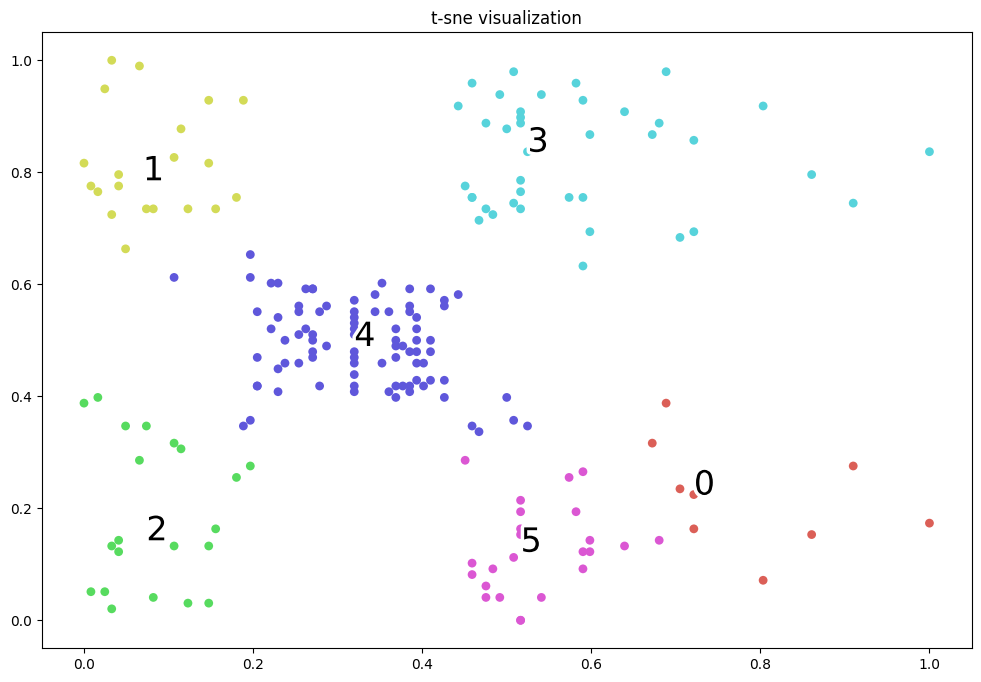

In [29]:
labels = best_gmm.predict(X_std)
_plot_kmean_scatter(X_std, labels)

##Ví dụ mở rộng

Dataset shape: (811, 107)
  Product_Code  W0  W1  W2  W3  W4  W5  W6  W7  W8  ...  Normalized 42  \
0           P1  11  12  10   8  13  12  14  21   6  ...           0.06   
1           P2   7   6   3   2   7   1   6   3   3  ...           0.20   
2           P3   7  11   8   9  10   8   7  13  12  ...           0.27   
3           P4  12   8  13   5   9   6   9  13  13  ...           0.41   
4           P5   8   5  13  11   6   7   9  14   9  ...           0.27   

   Normalized 43  Normalized 44  Normalized 45  Normalized 46  Normalized 47  \
0           0.22           0.28           0.39           0.50           0.00   
1           0.40           0.50           0.10           0.10           0.40   
2           1.00           0.18           0.18           0.36           0.45   
3           0.47           0.06           0.12           0.24           0.35   
4           0.53           0.27           0.60           0.20           0.20   

   Normalized 48  Normalized 49  Normalized 50  

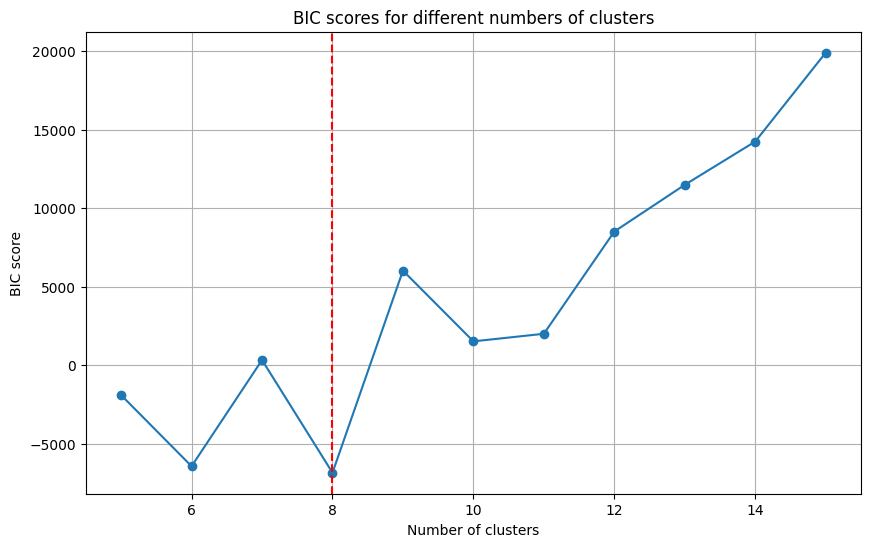

Optimal number of clusters: 8

Cluster sizes:
Cluster
0    288
1     23
2    156
3     45
4     37
5     25
6    202
7     35
Name: count, dtype: int64


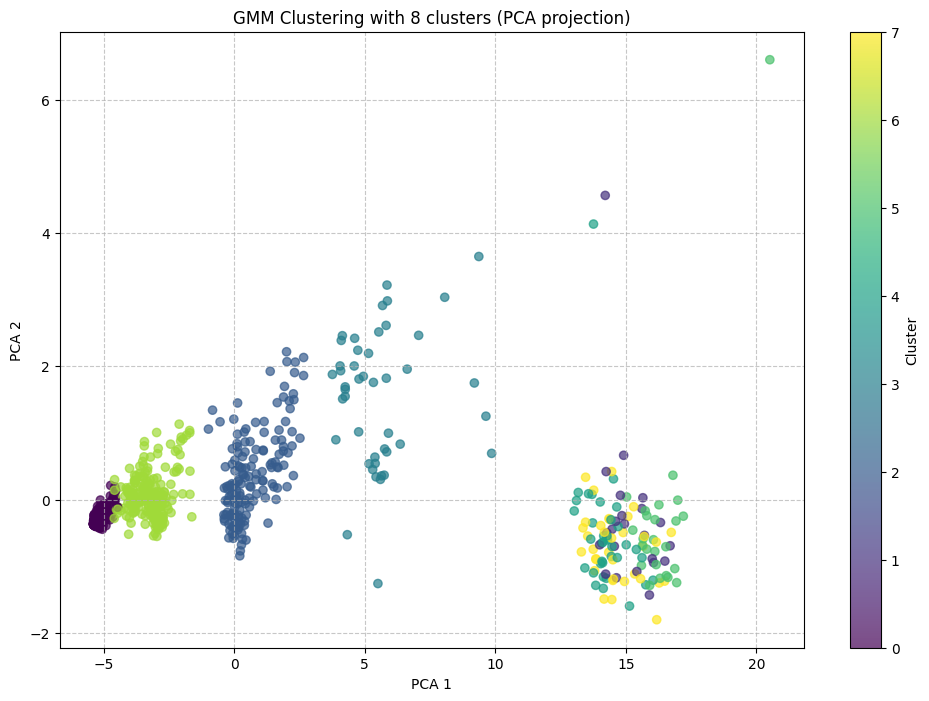

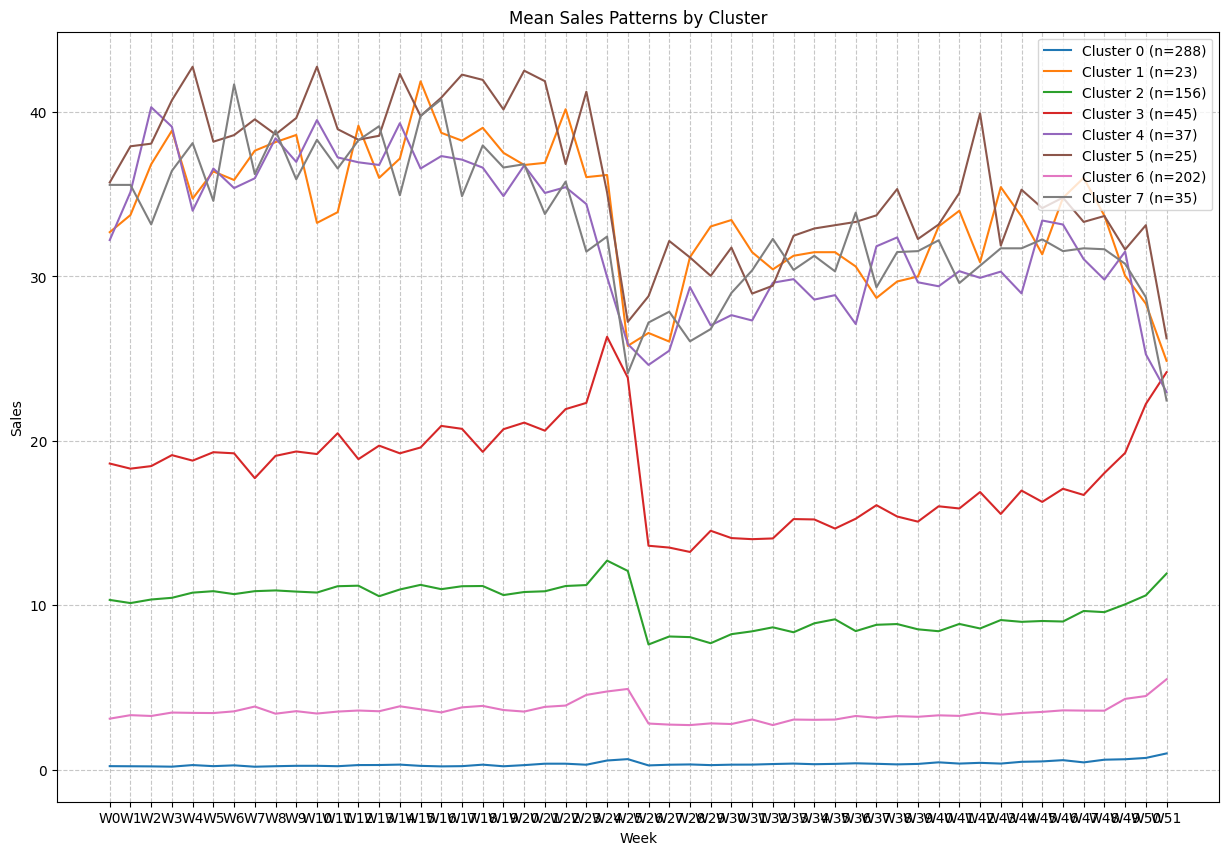


Results saved to 'product_clusters.csv'

Sample products from each cluster:
Cluster 0: ['P212', 'P213', 'P214', 'P215', 'P216']
Cluster 1: ['P16', 'P28', 'P36', 'P41', 'P47']
Cluster 2: ['P1', 'P3', 'P4', 'P5', 'P8']
Cluster 3: ['P10', 'P51', 'P62', 'P107', 'P200']
Cluster 4: ['P18', 'P19', 'P30', 'P42', 'P52']
Cluster 5: ['P15', 'P34', 'P35', 'P37', 'P38']
Cluster 6: ['P2', 'P6', 'P7', 'P12', 'P23']
Cluster 7: ['P17', 'P24', 'P25', 'P27', 'P40']

Cluster Characteristics:
           Avg Weekly Sales  Max Weekly Sales  Sales Variance  Product Count
Cluster 0          0.352965                 8        0.497852            288
Cluster 1         33.882107                63       42.718760             23
Cluster 2          9.934048                30       13.369911            156
Cluster 3         18.120085                50       28.324398             45
Cluster 4         32.488046                62       38.605827             37
Cluster 5         35.930769                73       50.38788

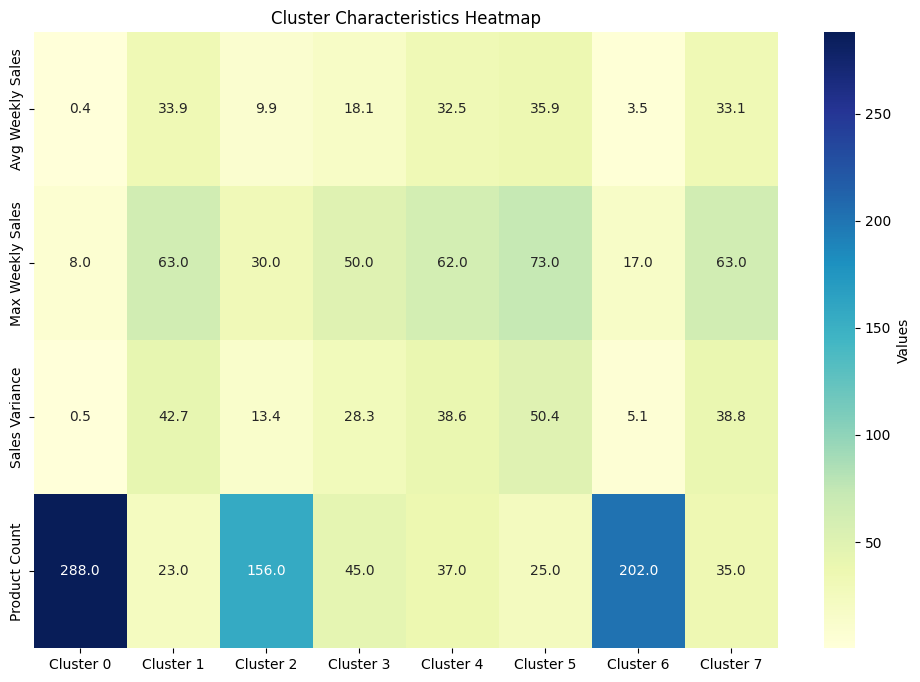

In [83]:
# Import các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # Bỏ qua các cảnh báo không quan trọng

# Đọc dữ liệu từ file CSV
df = pd.read_csv('/content/Sales_Transactions_Dataset_Weekly (1).csv')

# In kích thước dataset và 5 dòng đầu tiên
print(f"Dataset shape: {df.shape}")
print(df.head())

# Chỉ lấy các cột có tên bắt đầu bằng "W" (tuần)
weekly_data = df.filter(regex='^W[0-9]+$')

# Lưu lại mã sản phẩm
product_ids = df.iloc[:, 0]

# In kích thước và dữ liệu mẫu của phần dữ liệu theo tuần
print(f"Weekly data shape: {weekly_data.shape}")
print(weekly_data.head())

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
scaled_data = scaler.fit_transform(weekly_data)

# Hàm tìm số cụm tối ưu bằng cách sử dụng tiêu chí BIC
def find_optimal_clusters(data, max_k=15, min_k=5):
    n_components_range = range(min_k, max_k + 1)
    bic_scores = []

    for n_components in n_components_range:
        # Huấn luyện mô hình GMM với số cụm tương ứng
        gmm = GaussianMixture(n_components=n_components,
                              covariance_type='full',
                              random_state=42,
                              n_init=5,
                              max_iter=100)
        gmm.fit(data)
        bic_scores.append(gmm.bic(data))
        print(f"Fitted GMM with {n_components} clusters, BIC: {bic_scores[-1]}")

    # Chọn số cụm có BIC nhỏ nhất
    optimal_clusters = n_components_range[np.argmin(bic_scores)]

    # Vẽ biểu đồ BIC theo số cụm
    plt.figure(figsize=(10, 6))
    plt.plot(n_components_range, bic_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('BIC score')
    plt.title('BIC scores for different numbers of clusters')
    plt.axvline(x=optimal_clusters, color='r', linestyle='--')
    plt.grid(True)
    plt.savefig('bic_scores.png')
    plt.show()

    return optimal_clusters

# Tìm số lượng cụm tối ưu
print("Finding optimal number of clusters...")
optimal_clusters = find_optimal_clusters(scaled_data, max_k=15, min_k=5)
print(f"Optimal number of clusters: {optimal_clusters}")

# Áp dụng GMM với số cụm tối ưu
gmm = GaussianMixture(n_components=optimal_clusters,
                      covariance_type='full',
                      random_state=42,
                      n_init=5,
                      max_iter=100)
gmm.fit(scaled_data)
cluster_labels = gmm.predict(scaled_data)

# Thêm nhãn cụm vào DataFrame gốc
df['Cluster'] = cluster_labels

# In số lượng sản phẩm trong từng cụm
cluster_sizes = df['Cluster'].value_counts().sort_index()
print("\nCluster sizes:")
print(cluster_sizes)

# Giảm chiều dữ liệu để trực quan hóa cụm bằng PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Vẽ biểu đồ các cụm trong không gian 2D PCA
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.title(f'GMM Clustering with {optimal_clusters} clusters (PCA projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('cluster_visualization.png')
plt.show()

# Phân tích đặc điểm từng cụm
# Tính trung bình doanh số theo tuần của từng cụm
cluster_means = {}
for cluster in range(optimal_clusters):
    cluster_data = weekly_data[df['Cluster'] == cluster]
    cluster_means[cluster] = cluster_data.mean()

# Vẽ đồ thị mẫu doanh số trung bình cho từng cụm
plt.figure(figsize=(15, 10))
for cluster, means in cluster_means.items():
    plt.plot(means.index, means.values, label=f'Cluster {cluster} (n={cluster_sizes[cluster]})')
plt.title('Mean Sales Patterns by Cluster')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('cluster_patterns.png')
plt.show()

# Lưu kết quả phân cụm vào file CSV
df_results = df[['Product_Code', 'Cluster']].copy()
df_results['Cluster'] = df_results['Cluster'].astype(int)
df_results.to_csv('product_clusters.csv', index=False)
print("\nResults saved to 'product_clusters.csv'")

# In ra một vài sản phẩm tiêu biểu từ mỗi cụm
print("\nSample products from each cluster:")
for cluster in range(optimal_clusters):
    sample_products = product_ids[df['Cluster'] == cluster].head(5).tolist()
    print(f"Cluster {cluster}: {sample_products}")

# Phân tích thống kê tổng quan của từng cụm
print("\nCluster Characteristics:")
cluster_stats = pd.DataFrame()
for cluster in range(optimal_clusters):
    cluster_data = weekly_data[df['Cluster'] == cluster]
    stats = {
        'Avg Weekly Sales': cluster_data.mean().mean(),   # Doanh số trung bình mỗi tuần
        'Max Weekly Sales': cluster_data.max().max(),     # Doanh số cao nhất
        'Sales Variance': cluster_data.var().mean(),      # Độ biến động doanh số
        'Product Count': cluster_sizes[cluster]           # Số lượng sản phẩm trong cụm
    }
    cluster_stats = pd.concat([cluster_stats, pd.DataFrame(stats, index=[f'Cluster {cluster}'])])

print(cluster_stats)

# Vẽ heatmap thể hiện đặc trưng các cụm
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_stats.T, annot=True, cmap='YlGnBu', fmt='.1f', cbar_kws={'label': 'Values'})
plt.title('Cluster Characteristics Heatmap')
plt.savefig('cluster_heatmap.png')
plt.show()
